In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

### Data generation

In [62]:
data_path = '/home/jacobsuwang/Documents/PYTORCH/TUTORIAL/DATA/word-ordering/range10.txt'

MAX_LENGTH = 10

def nums_to_string(nums):
    return ' '.join([str(i) for i in nums])

def generate_rand(from_size, to_size, k=10):
    if from_size<2 or to_size>k:
        raise ValueError('min=2, max={}, but got min={}, max={}'.format(n, from_size, to_size))
    source = random.sample(range(2,k+2), random.choice(range(from_size, to_size)))
    input_string = nums_to_string(source)
    target_string = nums_to_string(sorted(source))
    return input_string, target_string

def generate_datafile(path, from_size, to_size, k=10, n=10000):
    with open(path, 'w') as f:
        for _ in range(n):
            input_string, target_string = generate_rand(from_size, to_size, k)
            f.write(input_string + '\t' + target_string + '\n')
        
# generate_datafile(data_path, 5, 10, k=MAX_LENGTH)

In [42]:
# Word-Index dict object

SOS_token = 0
EOS_token = 1

class Indexer:
    
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {}
        self.index2word = {0:'SOS', 1:'EOS'}
        self.n_words = 2
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [56]:
def read_data(indexer_name, path):
    lines = open(path, encoding='utf-8').read().strip().split('\n')
        # u'8 3 2 5 10\t2 3 5 8 10'
    pairs = [[s for s in l.split('\t')] for l in lines]
        # [u'8 3 2 5 10', u'2 3 5 8 10']
    indexer = Indexer(indexer_name) # empty now
    return indexer, pairs

In [73]:
def prepare_data(indexer_name, path):
    indexer, pairs = read_data(indexer_name, path)
    print('Read %s sentence pairs' % len(pairs))
    for pair in pairs:
        indexer.add_sentence(pair[0])
        indexer.add_sentence(pair[1])
    print('Counted words:')
    print(indexer.name, indexer.n_words)
    return indexer, pairs

indexer, pairs = prepare_data('range10', data_path)
print(random.choice(pairs))

Read 10000 sentence pairs
Counted words:
range10 12
[u'6 2 4 11 10 3 8 7 9', u'2 3 4 6 7 8 9 10 11']


In [74]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result       
        
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length) # in = prev_hidden & input (at t)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
            # Q. [0]: take the first elem in a batch-1 DS like [[*]]?
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            # unsqueeze(*) adds an extra dimension at dim-*.
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [88]:
def indexes_from_sentence(indexer, sentence):
    return [indexer.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(indexer, sentence):
    indexes = indexes_from_sentence(indexer, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result
    
def variables_from_pair(pair):
    input_variable = variable_from_sentence(indexer, pair[0])
    target_variable = variable_from_sentence(indexer, pair[1])
    return (input_variable, target_variable)

In [76]:
# Training function (Main)

teacher_forcing_ratio = 0.5 # probability where real target is fed to decoder

def train(input_variable, target_variable, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden() # get a 0-var with correct hidden_size from this.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_variable.size()[0] # Q. time-major now?
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    loss = 0
    for ei in range(input_length): # this varies from sent to sent.
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = encoder_hidden # this is the last encoder hidden state.
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [77]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [83]:
# Training functing (Manager)
#
#    - Start a timer
#    - Initialize optimizers and criterion
#    - Create set of training pairs
#    - Start empty losses array for plotting

def train_iters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=1e-2):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0  # ..
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variables_from_pair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        loss = train(input_variable, target_variable, 
                     encoder, decoder,
                     encoder_optimizer, decoder_optimizer, 
                     criterion)
        print_loss_total += loss
        plot_loss_total += loss
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter/n_iters),
                                         iter, iter/n_iters*100, print_loss_avg))
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    show_plot(plot_losses)
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [84]:
# Evaluation (decoding w/o teacher enforcing)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(indexer, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.init_hidden()
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]
            # Q. what is this?
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = encoder_hidden
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(indexer.index2word[ni])
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words, decoder_attentions[:di + 1] # in case break out early (max-len not reached).

def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0]) # input
        print('=', pair[1]) # gold
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence) # pred
        print('')

1m 30s (- 21m 3s) (5000 6%) 1.1108
2m 56s (- 19m 10s) (10000 13%) 0.6013
4m 23s (- 17m 32s) (15000 20%) 0.3855
5m 49s (- 15m 59s) (20000 26%) 0.2624
7m 15s (- 14m 30s) (25000 33%) 0.2554
8m 41s (- 13m 2s) (30000 40%) 0.2430
10m 8s (- 11m 35s) (35000 46%) 0.1869
11m 35s (- 10m 8s) (40000 53%) 0.2636
13m 1s (- 8m 41s) (45000 60%) 0.2216
14m 28s (- 7m 14s) (50000 66%) 0.1548
15m 54s (- 5m 47s) (55000 73%) 0.1958
17m 21s (- 4m 20s) (60000 80%) 0.2035
18m 47s (- 2m 53s) (65000 86%) 0.1838
20m 14s (- 1m 26s) (70000 93%) 0.1071
21m 41s (- 0m 0s) (75000 100%) 0.0883


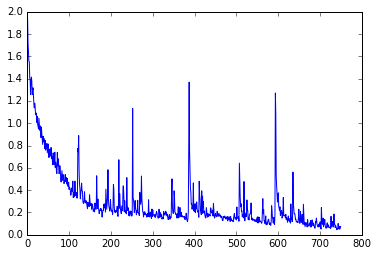

In [89]:
hidden_size = 10
encoder1 = EncoderRNN(indexer.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, indexer.n_words, dropout_p=0.1)
if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()
train_iters(encoder1, attn_decoder1, 75000, print_every=5000)

In [90]:
evaluate_randomly(encoder1, attn_decoder1)

> 8 11 9 2 3 7 4 10 6
= 2 3 4 6 7 8 9 10 11
< 2 3 4 6 7 8 9 10 11 <EOS>

> 11 7 3 4 5 8 10 6
= 3 4 5 6 7 8 10 11
< 3 4 5 6 7 8 10 11 <EOS>

> 10 3 8 11 7 4 5 2 6
= 2 3 4 5 6 7 8 10 11
< 2 3 4 5 6 7 8 10 11 <EOS>

> 11 2 4 9 6 3
= 2 3 4 6 9 11
< 2 3 4 6 9 11 <EOS>

> 11 2 5 6 9 10 3 4
= 2 3 4 5 6 9 10 11
< 2 3 4 5 6 9 10 11 <EOS>

> 4 8 7 10 3
= 3 4 7 8 10
< 3 4 7 8 10 <EOS>

> 4 11 7 3 5
= 3 4 5 7 11
< 3 4 5 7 11 <EOS>

> 4 8 7 9 10 3 2 5
= 2 3 4 5 7 8 9 10
< 2 3 4 5 7 8 9 10 <EOS>

> 4 7 3 9 11 8 5 10 2
= 2 3 4 5 7 8 9 10 11
< 2 3 4 5 7 8 9 10 11 <EOS>

> 8 10 6 4 3
= 3 4 6 8 10
< 3 4 6 8 10 <EOS>



input = 3 6 11 7 8
output = 3 6 7 8 11 <EOS>


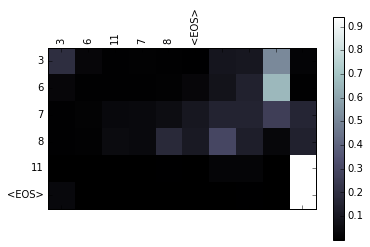

input = 4 11 10 6 2 3 5
output = 2 3 4 5 6 10 11 <EOS>


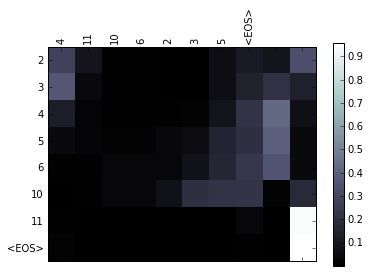

input = 9 5 6 3 8 10 7 4
output = 3 4 5 6 7 8 9 10 <EOS>


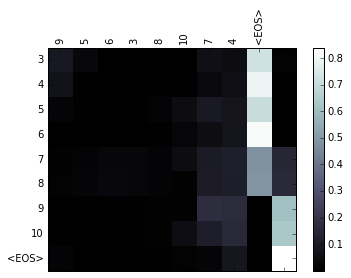

input = 3 2 10 4 6 11 9
output = 2 3 4 6 9 10 11 <EOS>


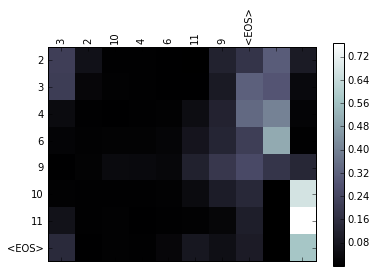

In [96]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)
    
evaluate_and_show_attention('3 6 11 7 8')

evaluate_and_show_attention('4 11 10 6 2 3 5')

evaluate_and_show_attention('9 5 6 3 8 10 7 4')

evaluate_and_show_attention('3 2 10 4 6 11 9')

In [95]:
generate_rand(5, 10)

(u'3 2 10 4 6 11 9', u'2 3 4 6 9 10 11')